# Deformation: Generate Displacements

In [ ]:
from aicsdeformation import AICSDeformation
import tifffile

cardio = "data/piv.tiff"
cardio = tifffile.imread(cardio)
cardio = AICSDeformation(cardio, t_index = 0)
cardio

In [ ]:
displacements = cardio.generate_displacements(n_threads=32)
displacements

In [ ]:
from aicsdeformation import processing

grid = processing.grid_search_displacements(frame_a=cardio[0], frame_b=cardio[1], n_threads=32)
grid

# Deformation: Streamline Plots

In [ ]:
from aicsdeformation import AICSDeformation
import tifffile

cardio = "data/piv.tiff"
cardio = tifffile.imread(cardio)
cardio = AICSDeformation(cardio, t_index = 0)
cardio

In [ ]:
# Best displacement parameters from small grid search of 625 parameter sets
# <DisplacementFromParameters [<Displacement [sig2noise: 1.4642163940655144]>, {'window_size': 26, 'overlap': 8, 'dt': 0.004, 'search_area_size': 26}]>
displacements = cardio.generate_displacements(window_size=26, overlap=8, dt=0.004, search_area_size=26)
cardio.displacements

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(9, int(len(cardio.displacements) / 11), figsize=(30, 20))
for i, ax in enumerate(axes.flatten()):
    ax.quiver(
        cardio.displacements[i].x,
        cardio.displacements[i].y,
        cardio.displacements[i].u,
        cardio.displacements[i].v,
#         density=[0.5, 1]
    )
    ax.set_title(f"From: {i}, To: {i + 1}")
    
plt.show()

# Deformation: Streamline Plot Overlaid On Animated Cardio

In [1]:
from aicsdeformation import AICSDeformation
import tifffile

cardio = "data/piv.tiff"
cardio = tifffile.imread(cardio)
cardio = AICSDeformation(cardio, t_index = 0)
cardio

<AICSDeformation [100 x (2048, 2048) frames]>

In [2]:
from aicsdeformation import processing

# Best displacement parameters from small grid search of 625 parameter sets
# <DisplacementFromParameters [<Displacement [sig2noise: 1.4642163940655144]>, {'window_size': 26, 'overlap': 8, 'dt': 0.004, 'search_area_size': 26}]>
entry  = processing.calculate_displacement((cardio[0], cardio[3]), window_size=26, overlap=8, dt=0.004, search_area_size=26)
processed = processing.process_displacement(entry, image_size=cardio.dims, window_size=26, overlap=8)

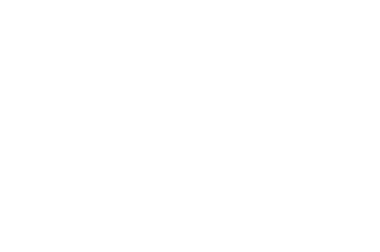

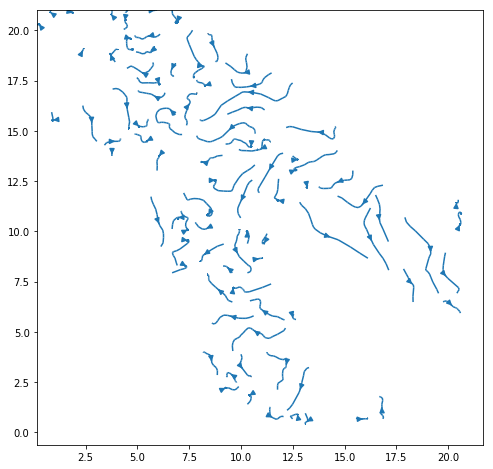

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.tight_layout(pad=0)
plt.axis("off")

fig, ax = plt.subplots(figsize=(8, 8))
ax.streamplot(processed.x, processed.y, processed.u, processed.v)

In [4]:
import sys
def normalize_imgs(imgs):
    imgs_min = sys.maxsize
    imgs_max = -1 * sys.maxsize
    for img in imgs:
        flat = img.flatten()
        current_min = np.min(flat)
        current_max = np.max(flat)
        
        if current_min < imgs_min:
            imgs_min = current_min
        if current_max > imgs_max:
            imgs_max = current_max
    
    for img in imgs:
        img -= imgs_min
        img = img / (imgs_max - imgs_min)

        img[img<0] = 0
        img[img>1] = 1

        img *= 255
        img = img.astype(int)
    
    return imgs

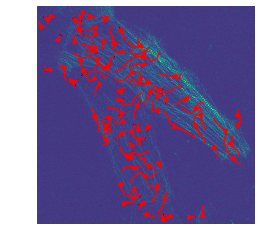

In [5]:
# setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image

rc('animation', html='html5')

# normalize and threshold
frames = normalize_imgs([cardio[0], cardio[3]])

fig, ax = plt.subplots();
plt.axis('off')

axesimage = ax.imshow(frames[0], extent=(0, 22, 0, 22));
ax.streamplot(processed.x, processed.y, processed.u, processed.v, color='r');

def animate(i):
    axesimage.set_data(frames[i%len(frames)])
    return (axesimage, )

anim = animation.FuncAnimation(fig, animate, frames=len(frames), interval=1000, blit=True)

In [ ]:
anim

# Naive Correlation Sort

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile
%matplotlib inline

cardio = "data/piv.tiff"
cardio = tifffile.imread(cardio)
cardio = [cardio[t, :, :] for t in range(cardio.shape[0])]
len(cardio)

In [ ]:
cardio[0], cardio[0].shape

In [ ]:
from aicsdeformation.preprocess import sort

frames, indices_map = sort.naive_correlation_sort(cardio)
indices_map

In [ ]:
plt.scatter(x=[details["original_index"] for i, details in indices_map.items()], y=[details["correlation"] for i, details in indices_map.items()])

In [ ]:
tifffile.imsave("data/sorted_piv.tiff", np.stack(frames, axis=0), metadata={"axis": "TYX"})